<h1 align="center">Spanish high speed rail ticket price prediction</h1>
<h2 align="center">(Advanced data science IBM specialization - capstone project)</h2>

### Project brief
#### Data source
Dataset used in this project was taken from Kaggle open datasets available by the following link: https://www.kaggle.com/thegurus/spanish-high-speed-rail-system-ticket-pricing

#### Data columns description:
- **insert_date:** date and time when price was collected, scrapping time (UTC)
- **origin:** origin city
- **destination:** destination city
- **start_date:** train departure time (European Central Time)
- **end_date:** train arrival time (European Central Time)
- **train_type:** train service name
- **price:** price (euros)
- **train_class:** ticket class, tourist, business, etc.
- **fare:** ticket fare, round trip, etc.

#### Justification
According to description available for this dataset, the goal of publishing this goal was to develop a Spanish High Speed Train Service (Renfe AVE) tickets pricing monitoring system. Ticket pricing changes based on demand and time, and there can be significant difference in price. Ideally such monitoring system will be able to predict a price reduction over mean price.

### Initial Data Exploration

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import os

%matplotlib inline

In [2]:
# Download the dataset as a csv file
df = pd.read_csv('renfe.csv', usecols=range(1, 10),
                 parse_dates=['insert_date', 'start_date', 'end_date'],
                 dtype={'price':float})

print('Number of rows: ', len(df))
df.head()

Number of rows:  2579771


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo
3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo
4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,NaN,Turista,Promo


In [3]:
# Check missing values
df.isnull().mean()

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.120430
train_class    0.003746
fare           0.003746
dtype: float64

In [4]:
# In this dataset there are ~2.6m rows. About 12% of price data is missing
# as well as less than 1% of train_class and fare columns. I'll remove missing
# price data from consideration and check missing values in the remaining dataset.

df = df[df.price>0]
df.isnull().mean()

insert_date    0.0
origin         0.0
destination    0.0
start_date     0.0
end_date       0.0
train_type     0.0
price          0.0
train_class    0.0
fare           0.0
dtype: float64

In [5]:
# Now there is no missing values. Check the date ranges

print('insert_date: from', df.insert_date.min(), 'to', df.insert_date.max())
print('start_date: from', df.start_date.min(), 'to', df.start_date.max())
print('end_date: from', df.end_date.min(), 'to', df.end_date.max())

insert_date: from 2019-04-11 21:49:46 to 2019-05-09 21:19:16
start_date: from 2019-04-12 05:50:00 to 2019-07-07 22:14:00
end_date: from 2019-04-12 08:38:00 to 2019-07-08 04:31:00


In [6]:
# Check datetime values

print('Insert_date later than start_date:', (df.insert_date >= df.start_date).sum())
print('Start_date later than end_date:', (df.start_date >= df.end_date).sum())

Insert_date later than start_date: 2795
Start_date later than end_date: 0


In [7]:
# Remove rows with invalid dates

df = df[df.insert_date < df.start_date]
print('Number of rows:', df.shape[0])

Number of rows: 2266295


In [8]:
# There are many categorical values in the dataset - let's check number of unique values

for col in df.columns:
    print(col, ":", df[col].unique().shape[0])

insert_date : 140031
origin : 5
destination : 5
start_date : 7560
end_date : 9772
train_type : 15
price : 225
train_class : 6
fare : 7


In [9]:
# All columns except the three datetime columns can be considered as categorical values!

# Check origin and destination:
pd.crosstab(df.destination, df.origin)

origin,BARCELONA,MADRID,PONFERRADA,SEVILLA,VALENCIA
destination,,,,,
BARCELONA,0,437896,0,0,0
MADRID,395691,0,71171,309147,315474
PONFERRADA,0,63433,0,0,0
SEVILLA,0,315726,0,0,0
VALENCIA,0,357757,0,0,0


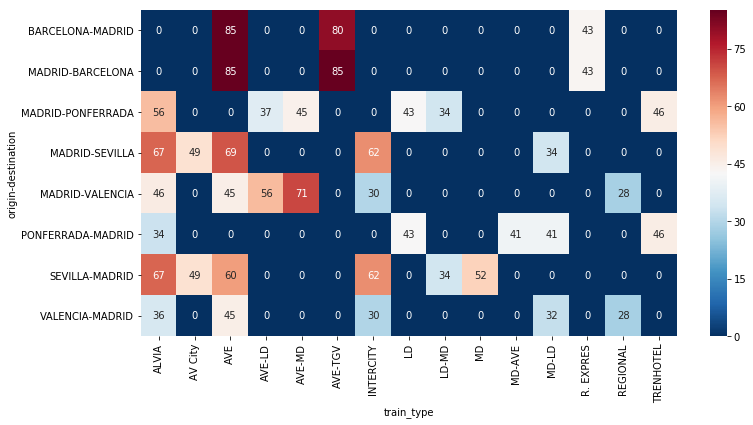

In [10]:
# Median Price for (origin, destination) vs (train_type)

figsize(12, 6)
sns.heatmap(pd.pivot_table(df,
                           columns='train_type',
                           index=['origin', 'destination'],
                           values='price',
                           fill_value=0,
                           aggfunc=np.median),
           annot=True, cmap="RdBu_r")

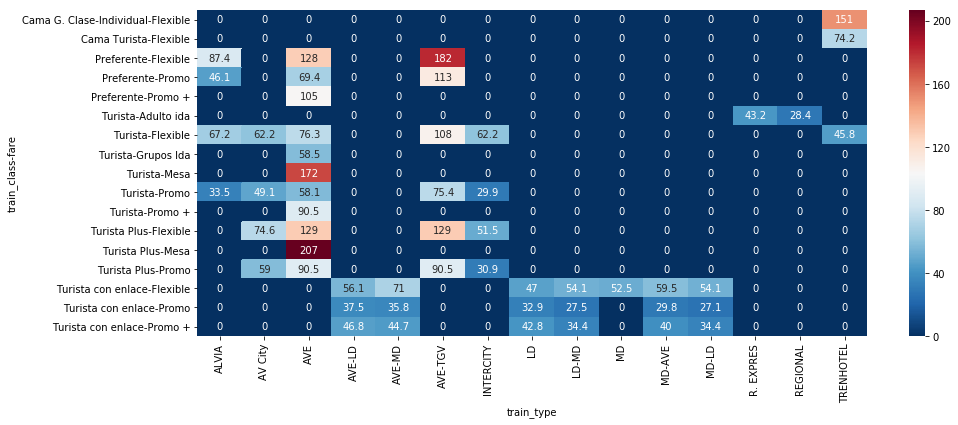

In [11]:
# Median Price for (train_class, fare) vs (train_type)

figsize(15, 6)
sns.heatmap(pd.pivot_table(data=df,
                           index=['train_class', 'fare'],
                           columns='train_type',
                           values='price',
                           fill_value=0,
                           aggfunc=np.median),
            annot=True, fmt=".3g", cmap="RdBu_r")

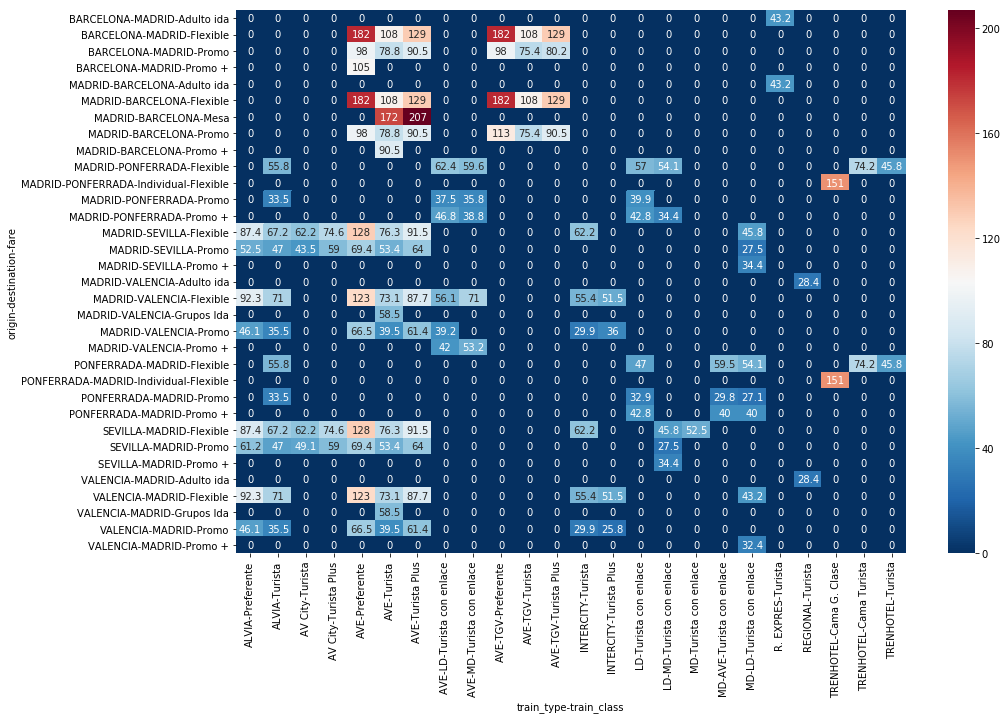

In [12]:
# Median Price for (origin, destination, fare) vs (train_type, train_class)

figsize(15, 10)
sns.heatmap(pd.pivot_table(df,
                           columns=['train_type', 'train_class'],
                           index=['origin', 'destination', 'fare'],
                           values='price',
                           fill_value=0,
                           aggfunc=np.median),
           annot=True, fmt=".3g", cmap="RdBu_r")

In [13]:
# Ticket price depends on all combinations of 'origin', 'destination', 'train_type',
# 'train_class' and 'fare' values. There are only several particular combinations available.

In [14]:
# Price categories

df.price.value_counts()

76.30     165707
28.35     141679
85.10     124480
60.30      83384
75.40      80203
107.70     76459
47.30      66485
53.40      65397
66.75      63710
33.65      56572
100.40     56498
57.75      54716
69.40      54716
39.45      53331
45.30      52965
51.15      43270
90.50      42061
27.80      39771
78.80      39697
21.95      36853
88.95      36562
58.15      35659
66.55      33410
80.15      33266
102.15     32329
62.20      30992
43.25      30990
73.10      28103
34.35      27481
49.15      25817
           ...  
49.54         29
54.35         26
21.93         25
38.70         24
90.45         22
115.67        21
51.35         18
51.50         17
21.30         17
75.15         16
45.60         15
66.53         15
159.60        10
47.35         10
112.53        10
29.75          9
58.50          6
58.47          5
59.48          5
27.78          5
28.20          3
83.49          3
105.00         3
51.17          2
43.20          2
40.93          1
16.75          1
85.15         

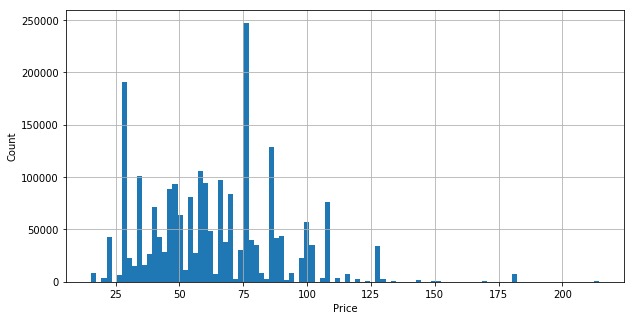

In [15]:
# Distribution of Price values

figsize(10, 5)
plt.hist(df.price.values, bins=100)
plt.xlabel("Price")
plt.ylabel("Count")
plt.grid()

### Feature ingineering

In [16]:
# Datetime features

df['trip_duration_hours'] = (df['end_date'] - df['start_date']).apply(lambda x: x.seconds/3600)
df['days_to_departure'] = (df['start_date'] - df['insert_date']).apply(lambda x: x.days + x.seconds/3600/24)

df['departure_time'] = df['start_date'].apply(lambda x: x.time())
df['departure_time_num'] = df['departure_time'].apply(lambda x: x.hour + x.minute/60)
df['departure_hour'] = df['start_date'].apply(lambda x: x.hour)
df['departure_dow'] = df['start_date'].apply(lambda x: x.day_name())
df['departure_dow_num'] = df['start_date'].apply(lambda x: x.dayofweek)
df['departure_daytime'] = ['night' if y<5 else ('early morning' if y<7 else ('morning' if y<12 else ('day' if y<18 else ('evening' if y<21 else 'night')))) for y in df.departure_hour.values]
df['departure_weekend'] = [1 if y in ['Saturday', 'Sunday'] else 0 for y in df.departure_dow.values]

df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,trip_duration_hours,days_to_departure,departure_time,departure_time_num,departure_hour,departure_dow,departure_dow_num,departure_daytime,departure_weekend
0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo,2.933333,40.033530,06:20:00,6.333333,6,Wednesday,2,early morning,0
1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo,2.533333,40.061308,07:00:00,7.000000,7,Wednesday,2,morning,0
2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo,2.350000,40.082141,07:30:00,7.500000,7,Wednesday,2,morning,0
3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo,2.533333,40.102975,08:00:00,8.000000,8,Wednesday,2,morning,0
5,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 09:00:00,2019-05-29 11:38:00,AVE,60.30,Turista,Promo,2.633333,40.144641,09:00:00,9.000000,9,Wednesday,2,morning,0


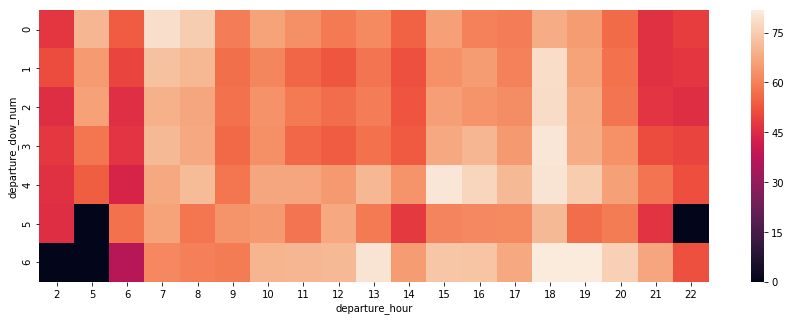

In [17]:
# Mean price for all trains (departure_dow_num) vs (departure_hour)

figsize(15, 5)
sns.heatmap(pd.pivot_table(data=df,
                           index='departure_dow_num',
                           columns = 'departure_hour',
                           values='price',
                           fill_value=0,
                           aggfunc=np.mean))

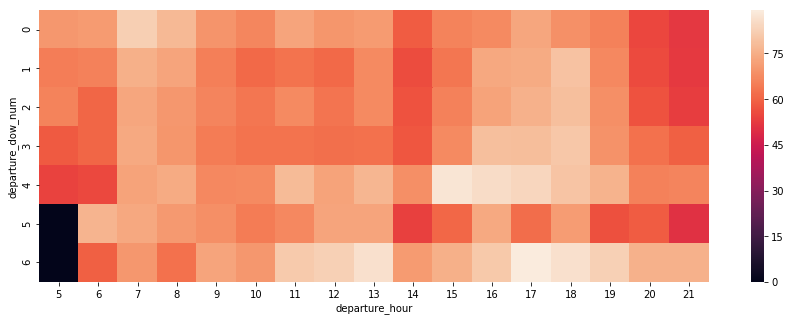

In [18]:
# Mean price for AVE trains

figsize(15, 5)
sns.heatmap(pd.pivot_table(data=df[df.train_type.str.startswith('AVE')],
                           index='departure_dow_num',
                           columns = 'departure_hour',
                           values='price',
                           fill_value=0,
                           aggfunc=np.mean))

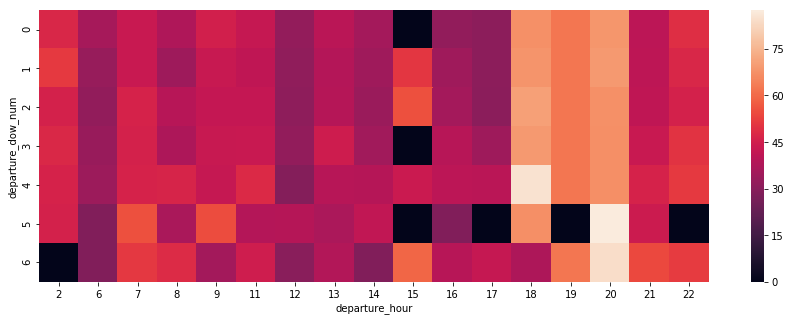

In [19]:
# Mean price for non-AVE trains

figsize(15, 5)
sns.heatmap(pd.pivot_table(data=df[~df.train_type.str.startswith('AVE')],
                           index='departure_dow_num',
                           columns = 'departure_hour',
                           values='price',
                           fill_value=0,
                           aggfunc=np.mean))

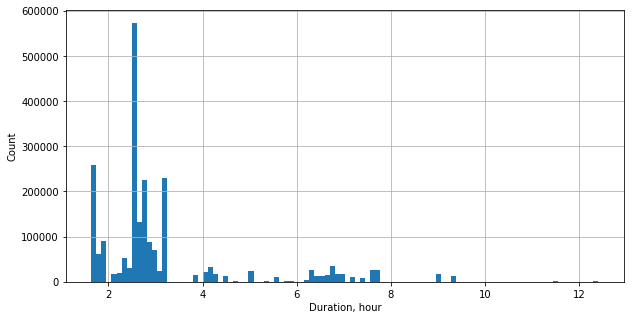

In [20]:
# Trip duration hours

figsize(10, 5)
plt.hist(df.trip_duration_hours.values, bins=100)
plt.xlabel("Duration, hour")
plt.ylabel("Count")
plt.grid()

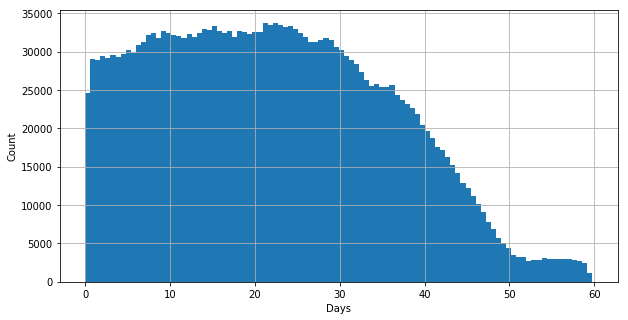

In [21]:
# Days to departure

figsize(10, 5)
plt.hist(df.days_to_departure.values, bins=100)
plt.xlabel("Days")
plt.ylabel("Count")
plt.grid()

In [22]:
# Other features

df['train_id'] = df[['origin', 'destination', 'start_date', 'end_date', 'train_type']].apply(lambda x: hash(tuple(x.tolist())), axis=1)
df['route_id'] = df[['origin', 'destination', 'train_type', 'departure_time', 'departure_dow']].apply(lambda x: hash(tuple(x.tolist())), axis=1)

df = df.assign(route = lambda x: x.origin + '-' + x.destination,
               route_name = lambda x: x.origin + '-' + x.destination + ' ' + x.train_type + ' ' + [str(y.hour).zfill(2) + ':' + str(y.minute).zfill(2) + ' ' + str(z) for y, z in zip(x.departure_time, x.departure_dow)],
               fare_class = lambda x: x.train_class + '-' + x.fare,
               test = lambda x: x.insert_date > pd.to_datetime('2019-05-01'))

print('#unique trains: ', len(df.train_id.unique()))
print('#unique routes: ', len(df.route_id.unique()))

#unique trains:  10708
#unique routes:  1095


In [23]:
# Ratio between train and test datasets

df.test.value_counts(normalize=True)

False    0.79797
True     0.20203
Name: test, dtype: float64

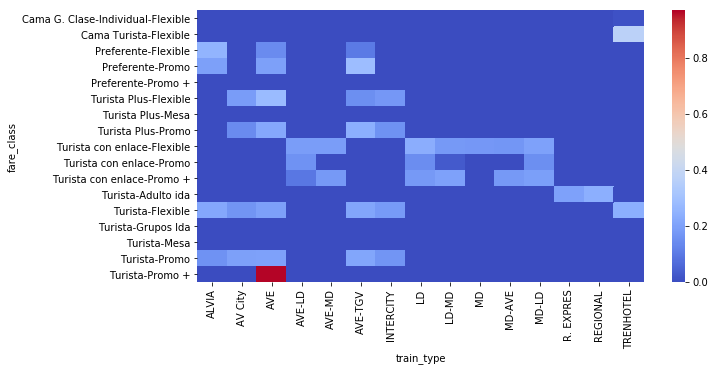

In [24]:
# Distribution of train_type, train_class and fare in train and test datasets

sns.heatmap(pd.pivot_table(data=df,
                           index='fare_class',
                           columns='train_type',
                           values='test',
                           aggfunc=np.mean,
                           fill_value=0), cmap='coolwarm')

In [25]:
# There is a potential problem in 'Turista-Promo +' fare_class!

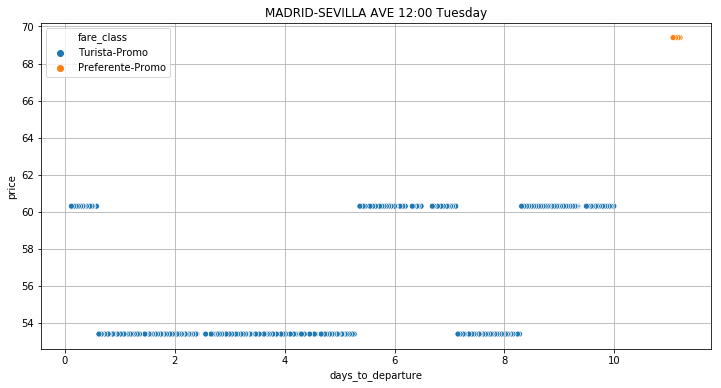

In [26]:
# How price changes for a particular train

figsize(12, 6)
sns.scatterplot(data=df[(df.train_id == df.train_id.unique()[30])],
                x='days_to_departure', y='price', hue='fare_class')
plt.title(df[(df.train_id == df.train_id.unique()[30])].route_name.values[0])
plt.grid()

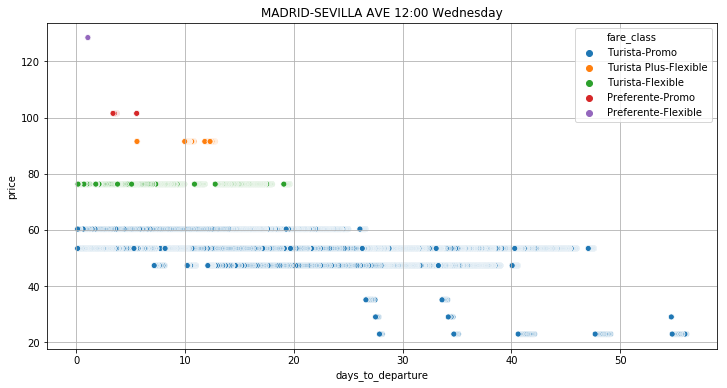

In [27]:
# How price changes for a particular route

figsize(12, 6)
sns.scatterplot(data=df[(df.route_id == df.route_id.unique()[8])],
                x='days_to_departure', y='price', hue='fare_class')
plt.title(df[(df.route_id == df.route_id.unique()[8])].route_name.values[0])
plt.grid()

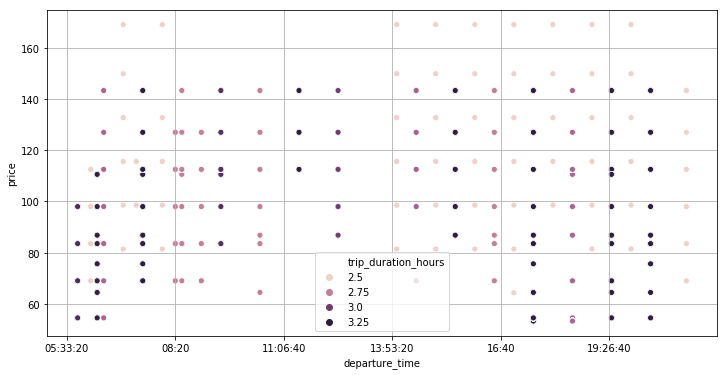

In [28]:
# How price changes depending on departure_time and trip_duration_hours

figsize(12, 6)
sns.scatterplot(data=df[(df.origin=='MADRID') & (df.destination=='BARCELONA') &
                        (df.train_type=='AVE') & (df.fare_class=='Preferente-Promo')],
               x='departure_time', y='price', hue='trip_duration_hours')
plt.grid()

### Correlations

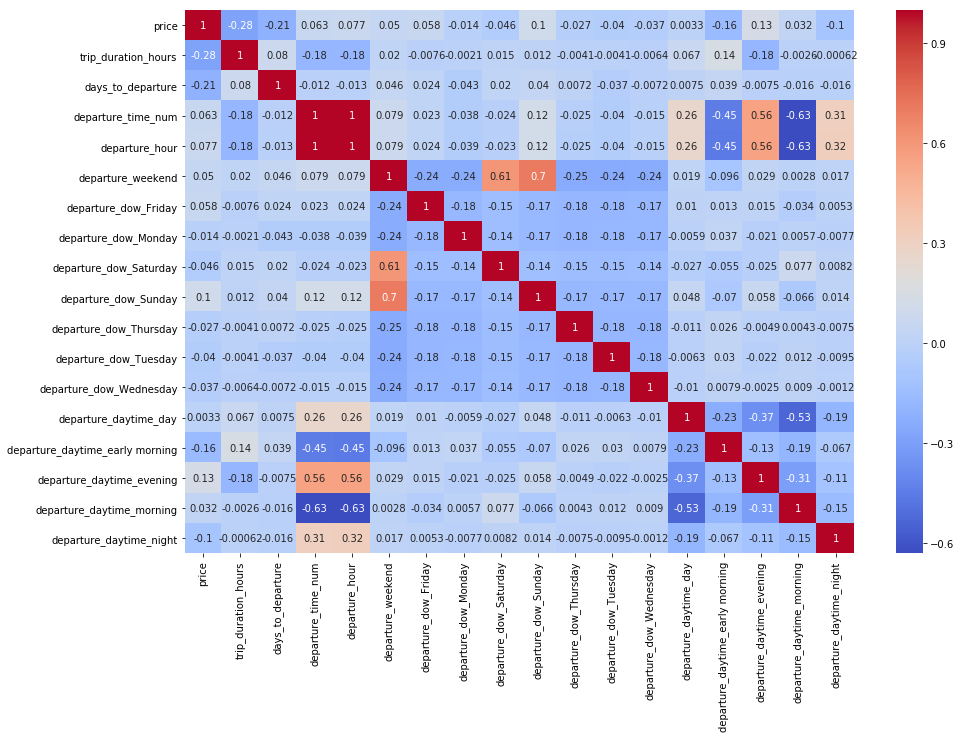

In [29]:
# Correlation of price and datetime features in train dataset

figsize(15, 10)
sns.heatmap(pd.get_dummies(df.loc[df.test==0, ['price', 'trip_duration_hours', 'days_to_departure',
                                               'departure_time_num', 'departure_hour', 'departure_dow',
                                               'departure_daytime', 'departure_weekend']],
                           columns=['departure_dow', 'departure_daytime']).corr(),
            annot=True, cmap='coolwarm')

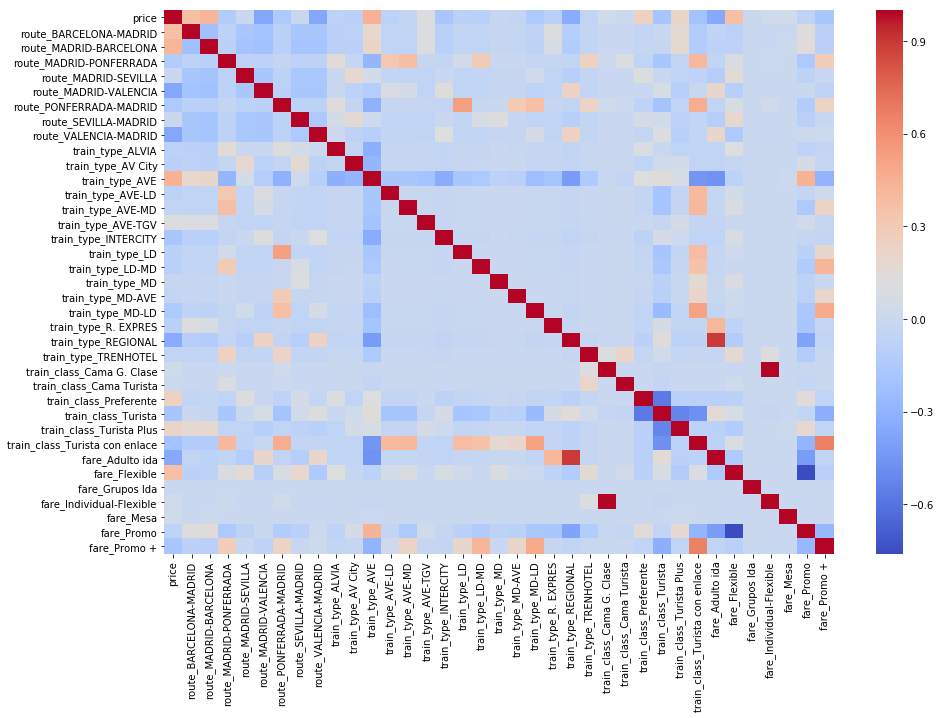

In [30]:
# Correlation of price and other features in train dataset

figsize(15, 10)
sns.heatmap(pd.get_dummies(df.loc[df.test==0, ['price', 'route', 'train_type', 'train_class', 'fare']],
                           columns=['route', 'train_type', 'train_class', 'fare']).corr(),
            annot=False, cmap='coolwarm')

In [31]:
# Save all data

(df.drop(columns=['departure_time'])
 .rename(columns={'departure_time_num':'departure_time'})
 .to_csv('renfe_transformed.csv', index=False))